# 1st Hackathon

## 팀이름 :  LCKRegressor

## 준비한 데이터
- air_visit_data.csv
- date_info.csv
- air_store_info.csv
- hpg_store_info.csv
- air_reserve.csv
- hpg_reserve.csv
- store_id_relation.csv
- sample_submission.csv

## 시각화
- 날짜별 방문자 추이
- 날짜별 예약자 추이
- Holiday, NonHoliday 평균 방문자수
- 다음날이 Holiday인 평균 방문자수
- genre, area 별 빈도

## 전처리 과정 순서
1. air_visit_data와 submission에서 날짜 분리 ex) 2021-06-01 --> 2021, 06, 01
2. date_info에서 holiday인 날과 다음날이 holiday인 경우를 0,1로 대입
3. air_store와 hpg_store에서 genre와 area, 위도, 경도 추가
4. air_reserve와 hpg_reserve에서 시간별 예약자수 컬럼으로 추가. 예약이 없으면 -1
5. maxmin 정규화
6. Grid search

## 사용 모델
- RandomForestRegressor
- GradientBoostingRegressor
- XGBRegressor
- LGBMRegressor
- Keras dense layer

## 필요한 라이브러리 import

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn 
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import tensorflow as tf
import matplotlib
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import os
from os.path import join
%matplotlib inline

# air_visit_data / date_info 파일의 시각화

## Air visits

Text(0, 0.5, 'Number of Visitors')

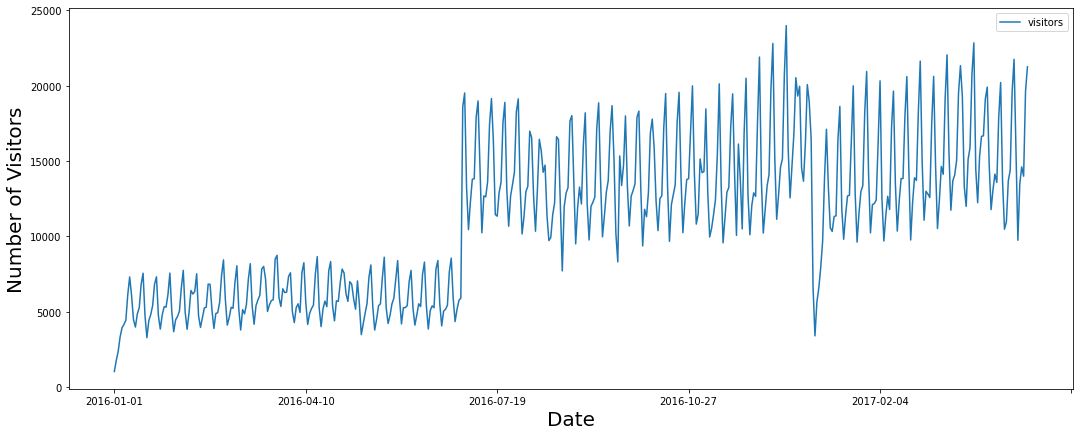

In [2]:
# 데이터 호출
air_visit_data = pd.read_csv('air_visit_data.csv')
date_info = pd.read_csv('date_info.csv')

#data info를 호출해서 holiday 인지아닌지 0,1,로 추가
# 다음날이 holiday 인지 아닌지 0,1로 추가
holiday=date_info['holiday_flg']

next_holiday = []
for i in range(len(holiday)):
    try:
        next_holiday.append(holiday.iloc[i+1])
    except:
        next_holiday.append(0)
#dataframe을 합치기 위해 list를 dataframe으로 전환
next_holiday=pd.DataFrame(next_holiday)
#합치기
date_info['next_holiday'] = next_holiday

visitors_by_date = air_visit_data.groupby('visit_date').sum()
ax = visitors_by_date.plot(figsize=[18,7])
# x축 라벨 설정
plt.xlabel('Date',fontsize= 20)
# y축 라벨 설정
plt.ylabel("Number of Visitors",fontsize= 20)

- 고객의 수가 위 아래로 등락 폭을 보이는데, 이는 일주일 정도의 패턴을 가진 것으로 보인다.
- 2016년 7월 부터 고객의 수가 급격히 증가한다.
    - air_visit 데이터는 년도와 월을 반영할 필요가 있었다.

## holiday의 개수 및 holiday이 미치는 영향

In [3]:
display(date_info.groupby('day_of_week').agg({'holiday_flg':'sum'}).sort_values(by='holiday_flg', ascending=False).reset_index())

# holiday의 개수 
print("holiday의 개수 : ",date_info['holiday_flg'].sum())

,day_of_week,holiday_flg
0,Monday,9
1,Thursday,7
2,Friday,5
3,Saturday,5
4,Sunday,4
5,Wednesday,3
6,Tuesday,2


holiday의 개수 :  35


holiday는 월요일이 9번으로 가장 많고 총 35개인 걸 알 수 있다.

In [4]:
# 데이터 병합
total = pd.merge(air_visit_data, date_info, how='left', left_on='visit_date', right_on='calendar_date')
total.groupby('holiday_flg').mean()

,visitors,next_holiday
holiday_flg,,
0,20.828064,0.042827
1,23.703327,0.305284


- visitors 휴일이 아닌날에서 다음날 휴일일때 방문자 수 평균 20명, 휴일인날 다음날이 휴일일 때 23.7명

- 오늘이 휴일이 아니고 다음날이 휴일일 확률이 4%, 오늘이 휴일이고 다음날이 휴일일 확률이 30%

holiday인 날이 평균적으로 방문자수가 더 많은 걸 알 수 있다.

In [5]:
# 데이터 병합
total = pd.merge(air_visit_data, date_info, how='left', left_on='visit_date', right_on='calendar_date')
total.groupby('next_holiday').mean()

,visitors,holiday_flg
next_holiday,,
0,20.754293,0.037296
1,24.664523,0.275618


공휴일 전날은 그렇지 않은 날에 비해 1.2 배 가량의 방문객 수가 많으므로, 독립변수로 추가하는게 좋을것같다.

# air_visit_data / date_info 파일의 전처리

In [6]:
#1번
#air visit 호출 
air_visit_data = pd.read_csv('air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
#날짜 분리
air_visit_data['year'] = air_visit_data['visit_date'].str[:4]
air_visit_data['month'] = air_visit_data['visit_date'].str[5:7]
air_visit_data['day'] = air_visit_data['visit_date'].str[-2:]
air_visit_data['dow'] = pd.to_datetime(air_visit_data['visit_date']).dt.dayofweek

#변수순서 바꾸기 visitors를 맨 뒤로
air_visit_data1 = air_visit_data[['store_id','visit_date','year','month','day','dow','visitors']]
air_visit_data.head(3)

,store_id,visit_date,visitors,year,month,day,dow
0,air_ba937bf13d40fb24,2016-01-13,25,2016,01,13,2
1,air_ba937bf13d40fb24,2016-01-14,32,2016,01,14,3
2,air_ba937bf13d40fb24,2016-01-15,29,2016,01,15,4


In [7]:
print('날짜 분리 전처리')
air_visit_data1.head(3)

날짜 분리 전처리


,store_id,visit_date,year,month,day,dow,visitors
0,air_ba937bf13d40fb24,2016-01-13,2016,01,13,2,25
1,air_ba937bf13d40fb24,2016-01-14,2016,01,14,3,32
2,air_ba937bf13d40fb24,2016-01-15,2016,01,15,4,29


In [8]:
#2번 
#submission 호출 후 air visit 아래로 합치기
sample_submission = pd.read_csv('sample_submission.csv')
#가게 날짜를 나눔
sample_submission['store_id'] = sample_submission['id'].str[:-11]
sample_submission['visit_date'] = sample_submission['id'].str[-10:]
sample_submission['year'] = sample_submission['id'].str[-10:-6]
sample_submission['month'] = sample_submission['id'].str[-5:-3]
sample_submission['day'] = sample_submission['id'].str[-2:]
sample_submission['dow'] = pd.to_datetime(sample_submission['visit_date']).dt.dayofweek
#air visit에 맞게 변수 순서 바꾸기
sample_submission1 = sample_submission[['store_id','visit_date','year','month','day','dow','visitors']]
sample_submission.head(3)

,id,visitors,store_id,visit_date,year,month,day,dow
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,2017,04,23,6
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,2017,04,24,0
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,2017,04,25,1


In [9]:
sample_submission1.head(3)

,store_id,visit_date,year,month,day,dow,visitors
0,air_00a91d42b08b08d9,2017-04-23,2017,04,23,6,0
1,air_00a91d42b08b08d9,2017-04-24,2017,04,24,0,0
2,air_00a91d42b08b08d9,2017-04-25,2017,04,25,1,0


In [10]:
#1번과 2번을 합쳐서 전처리
data = pd.concat([air_visit_data1, sample_submission1])
#3번까지 완료
data=data.reset_index(drop=True)
print(air_visit_data1.shape)
print(sample_submission1.shape)
print('252108 + 32019 = ', 252108+32019)
print(data.shape)
data.head(3)

(252108, 7)
(32019, 7)
252108 + 32019 =  284127
(284127, 7)


,store_id,visit_date,year,month,day,dow,visitors
0,air_ba937bf13d40fb24,2016-01-13,2016,01,13,2,25
1,air_ba937bf13d40fb24,2016-01-14,2016,01,14,3,32
2,air_ba937bf13d40fb24,2016-01-15,2016,01,15,4,29


In [11]:
#4번
#data info를 호출해서 holiday 인지아닌지 0,1,로 추가
date_info = pd.read_csv('date_info.csv').rename(columns={'calendar_date':'visit_date'}).drop('day_of_week', axis=1)
# 다음날이 holiday 인지 아닌지 0,1로 추가
holiday=date_info['holiday_flg']

next_holiday = []
for i in range(len(holiday)):
    try:
        next_holiday.append(holiday.iloc[i+1])
    except:
        next_holiday.append(0)
#dataframe을 합치기 위해 list를 dataframe으로 전환
next_holiday=pd.DataFrame(next_holiday)
#합치기
date_info['next_holiday'] = next_holiday
#data에 통합시키기
data = pd.merge(data,date_info,how='right', on = 'visit_date' )

data.head(3)

,store_id,visit_date,year,month,day,dow,visitors,holiday_flg,next_holiday
0,air_d0e8a085d8dc83aa,2016-01-01,2016,01,01,4,8,1,1
1,air_5c65468938c07fa5,2016-01-01,2016,01,01,4,8,1,1
2,air_f690c42545146e0a,2016-01-01,2016,01,01,4,7,1,1


================================================================================================================

# air_store_info / hpg_store_info 파일의 시각화

## 사용한 파일
air_store_info.csv  
hpg_store_info.csv

# air store 시각화

## (1) air_genre_name 빈도 시각화

In [12]:
# 데이터 호출
air_store_info = pd.read_csv('air_store_info.csv')
hpg_store_info = pd.read_csv('hpg_store_info.csv')

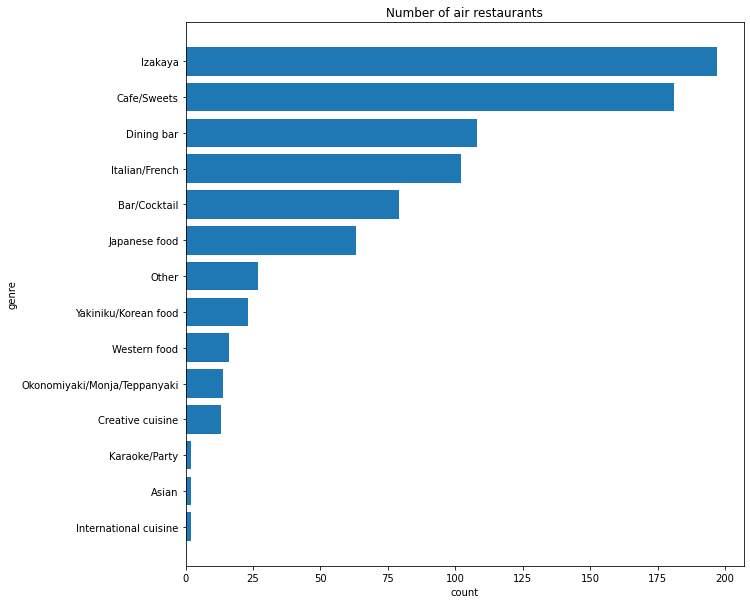

In [13]:
air_genre = air_store_info['air_genre_name']

# air_genre_list를 생성
air_genre_list=[]

for i in air_genre:
    if i not in air_genre_list:
        air_genre_list.append(i)

# air_genre_list별 몇번 나오는지 호출
count=0
air_genre_count=[]
for i in air_genre_list:
    for j in air_genre:
        if i == j:
            count+=1
    air_genre_count.append(count)
    count=0
    
# list를 병합하기위해 데이터프레임으로 형식을 바꿔줌
air_genre_list=pd.DataFrame(air_genre_list)
air_genre_count=pd.DataFrame(air_genre_count)

# list와 count를 통합
total_air_genre = pd.concat([air_genre_list,air_genre_count],axis=1)
total_air_genre.columns =['genre_list','count']

# 가장 많은 가게를 위로 올리는 정렬
total_air_genre = total_air_genre.sort_values(by=['count'], axis =0,)

# 막대그래프 시각화
plt.figure(figsize=(10,10))
# 타이틀 설정
plt.title('Number of air restaurants')
# x축 라벨 설정
plt.xlabel('count')
# y축 라벨 설정
plt.ylabel('genre')
# 막대 그래프(x, y)
plt.barh(total_air_genre['genre_list'], total_air_genre['count'])
# 그래프 출력
plt.show()

이자카야 타입이 가장 많고, 다음이 카페이다. ‘Karaoke’와 ’International’, ‘Asian’ 타입 식당은 적어 보인다.

## (2) air_area_name 별 빈도 시각화

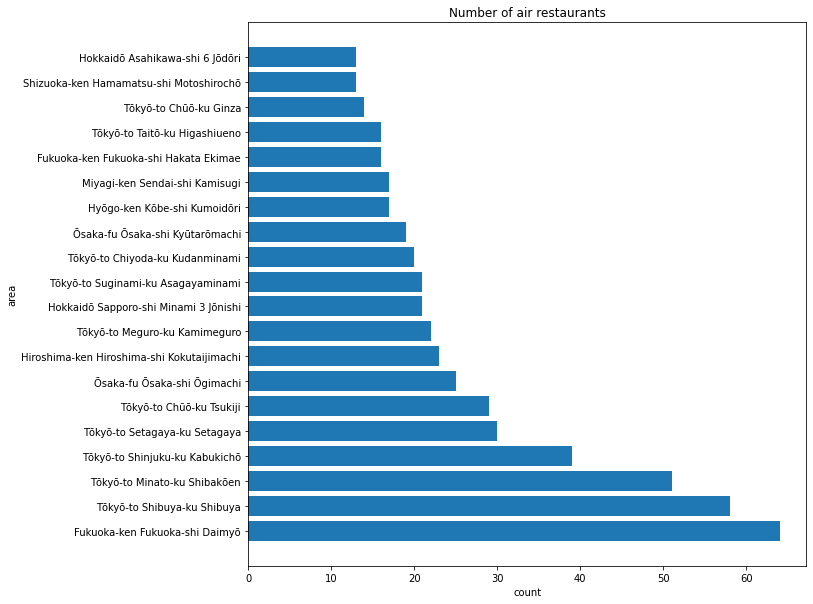

In [14]:
air_area = air_store_info['air_area_name']

# air_area_list를 생성
air_area_list=[]

for i in air_area:
    if i not in air_area_list:
        air_area_list.append(i)

# air_area_list별 몇번 나오는지 호출
count=0
air_area_count=[]
for i in air_area_list:
    for j in air_area:
        if i == j:
            count+=1
    air_area_count.append(count)
    count=0

# list를 병합하기위해 데이터프레임으로 형식을 바꿔줌
air_area_list=pd.DataFrame(air_area_list)
air_area_count=pd.DataFrame(air_area_count)

# list와 count를 통합
total_air_area = pd.concat([air_area_list,air_area_count],axis=1)
total_air_area.columns =['area_list','count']

# 가장 많은 가게를 위로 올리는 정렬
total_air_area = total_air_area.sort_values(by=['count'], axis =0, ascending=False)

#막대그래프 시각화
plt.figure(figsize=(10,10))
# 타이틀 설정
plt.title('Number of air restaurants')
# x축 라벨 설정
plt.xlabel('count')
# y축 라벨 설정
plt.ylabel('area')
# 막대 그래프(x, y)
plt.barh(total_air_area['area_list'][:20], total_air_area['count'][:20])
# 그래프 출력
plt.show()

후쿠오카는 면적당 air restaurants가 가장 많다. 그 뒤를 이어 Tokyo 지역이다.

## (3) 지도에 시각화

In [15]:
map = folium.Map(location = [39, 140], zoom_start=5)

list1=[]
list2=[]
marker_cluster = MarkerCluster().add_to(map)
for a in air_store_info.index:
    folium.Marker(location = [air_store_info.loc[a,"latitude"],air_store_info.loc[a,"longitude"]],
                  zoom_start=12).add_to(marker_cluster)
    list1.append(air_store_info.loc[a,"latitude"])
    list2.append(air_store_info.loc[a,"longitude"])

map

air에 가입된 식당의 도시별 분포를 알 수 있다.

# hpg store 시각화

## (1) hpg_genre_name 빈도 시각화

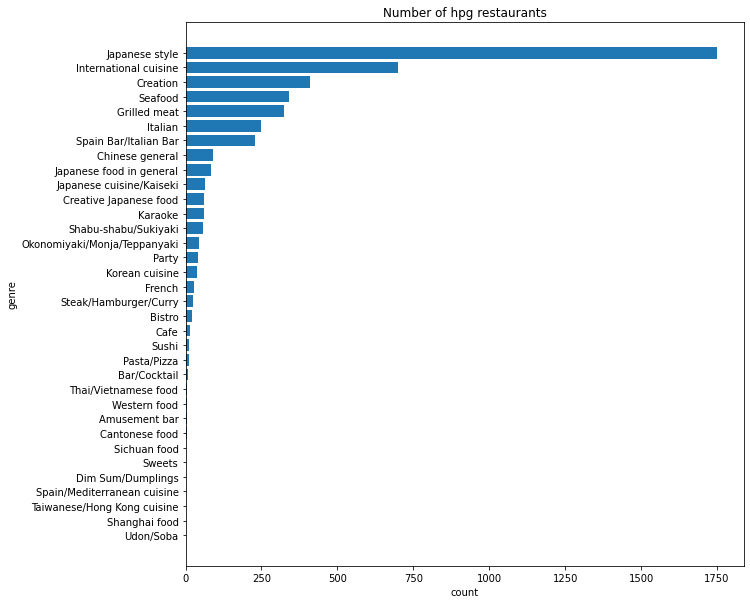

In [16]:
# hpg_genre_name 빈도 시각화
hpg_genre=hpg_store_info['hpg_genre_name']

# hpg_genre_list를 생성
hpg_genre_list=[]

for i in hpg_genre:
    if i not in hpg_genre_list:
        hpg_genre_list.append(i)


# hpg_genre_list별 몇번 나오는지 호출
count=0
hpg_genre_count=[]
for i in hpg_genre_list:
    for j in hpg_genre:
        if i == j:
            count+=1
    hpg_genre_count.append(count)
    count=0


# list를 병합하기위해 데이터프레임으로 형식을 바꿔줌
hpg_genre_list=pd.DataFrame(hpg_genre_list)
hpg_genre_count=pd.DataFrame(hpg_genre_count)

# list와 count를 통합
total_hpg_genre = pd.concat([hpg_genre_list,hpg_genre_count],axis=1)
total_hpg_genre.columns =['genre_list','count']


# 가장 많은 가게를 위로 올리는 정렬
total_hpg_genre = total_hpg_genre.sort_values(by=['count'], axis =0,)

# 막대그래프 시각화
plt.figure(figsize=(10,10))
# 타이틀 설정
plt.title('Number of hpg restaurants')
# x축 라벨 설정
plt.xlabel('count')
# y축 라벨 설정
plt.ylabel('genre')
# 막대 그래프(x, y)
plt.barh(total_hpg_genre['genre_list'], total_hpg_genre['count'])
# 그래프 출력
plt.show()

hpg 설명에는 air data보다 많은 genre 분류가 있다. air data에선 세분화된 많은 분류들이  
여기에선 ’Japanese Style’에 포함된 것 처럼 보인다. ’International cuisine.’은 동일하게 있다.

## (2) hpg_area_name 별 빈도 시각화

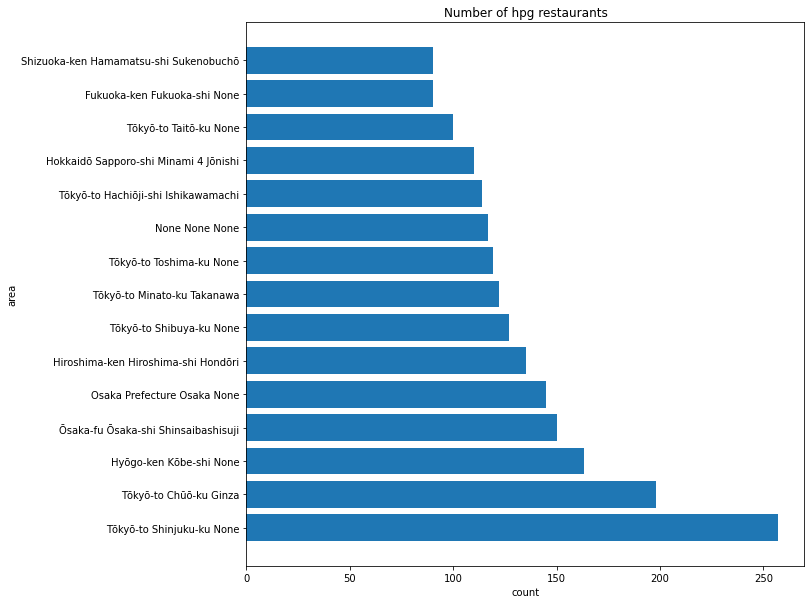

In [17]:
# hpg_area_name 별 빈도 시각화
hpg_area=hpg_store_info['hpg_area_name']

# hpg_area_list를 생성
hpg_area_list=[]

for i in hpg_area:
    if i not in hpg_area_list:
        hpg_area_list.append(i)

# hpg_area_list별 몇번 나오는지 호출
count=0
hpg_area_count=[]
for i in hpg_area_list:
    for j in hpg_area:
        if i == j:
            count+=1
    hpg_area_count.append(count)
    count=0

# list를 병합하기위해 데이터프레임으로 형식을 바꿔줌
hpg_area_list=pd.DataFrame(hpg_area_list)
hpg_area_count=pd.DataFrame(hpg_area_count)

# list와 count를 통합
total_hpg_area = pd.concat([hpg_area_list,hpg_area_count],axis=1)
total_hpg_area.columns =['area_list','count']

# 가장 많은 가게를 위로 올리는 정렬
total_hpg_area = total_hpg_area.sort_values(by=['count'], axis =0, ascending=False)

# 막대그래프 시각화
plt.figure(figsize=(10,10))
# 타이틀 설정
plt.title('Number of hpg restaurants')
# x축 라벨 설정
plt.xlabel('count')
# y축 라벨 설정
plt.ylabel('area')
# 막대 그래프(x, y)
plt.barh(total_hpg_area['area_list'][:15], total_hpg_area['count'][:15])
# 그래프 출력
plt.show()

도쿄와 오사카가 많이 들어 있음을 알 수 있다.

## (3) 지도에 시각화

In [18]:
map = folium.Map(location = [39, 140], zoom_start=5)

list1=[]
list2=[]
marker_cluster = MarkerCluster().add_to(map)
for a in hpg_store_info.index:
    folium.Marker(location = [hpg_store_info.loc[a,"latitude"],hpg_store_info.loc[a,"longitude"]],
                  zoom_start=12).add_to(marker_cluster)
    list1.append(hpg_store_info.loc[a,"latitude"])
    list2.append(hpg_store_info.loc[a,"longitude"])
    
map

#### 알 수 있는 것
hpg에 가입된 식당의 도시별 분포.  
air에 비해 hpg를 이용하는 사람의 수가 많다.

# air store, hpg store 전처리

In [19]:
#5번
#air_store_info 호출
air_store_info = pd.read_csv('air_store_info.csv',error_bad_lines=False).rename(columns={'air_store_id':'store_id'})
#id에 맞는 genre랑 area encoding은 나중에하자
#encoding하거랑 경도 위도 같이 air_visit에 추가
data = pd.merge(data,air_store_info,how='right', on = 'store_id' )
data['latitude']=round(data['latitude'])
data['longitude']=round(data['longitude'])
data.head(3)

,store_id,visit_date,year,month,day,dow,visitors,holiday_flg,next_holiday,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,2016-07-01,2016,07,01,4,18,0,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,35.0,135.0
1,air_0f0cdeee6c9bf3d7,2016-07-02,2016,07,02,5,37,0,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,35.0,135.0
2,air_0f0cdeee6c9bf3d7,2016-07-03,2016,07,03,6,20,0,0,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,35.0,135.0


In [20]:
#6번
#hpg_store_info 호출
hpg_store_info = pd.read_csv('hpg_store_info.csv',error_bad_lines=False)
store_id_relation = pd.read_csv('store_id_relation.csv').rename(columns={'air_store_id':'store_id'})
store_id_relation = store_id_relation[['hpg_store_id','store_id']]
#store_id를 열어서 air id로 바꾸기
hpg_store_info = pd.merge(hpg_store_info,store_id_relation, on = 'hpg_store_id' )
hpg_store_info=hpg_store_info[['store_id','hpg_genre_name']]
#hpg와 air가 겹치는 genre는 들어가고 없는애들은 0으로 들어감
data = pd.merge(data,hpg_store_info,how='outer', on = 'store_id' )
data['hpg_genre_name'] = data['hpg_genre_name'].fillna('0')


================================================================================================================

# air_reserve / hpg_reserve 파일의 시각화


## 사용한 파일
air_reserve.csv  
hpg_reserve.csv

In [21]:
# 데이터 호출
air_reserve = pd.read_csv("air_reserve.csv")
hpg_reserve = pd.read_csv("hpg_reserve.csv")

# 시간 제거
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime']).dt.date
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime']).dt.date
hpg_reserve['reserve_datetime'] = pd.to_datetime(hpg_reserve['reserve_datetime']).dt.date
hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime']).dt.date

## air reserve 파일 시각화

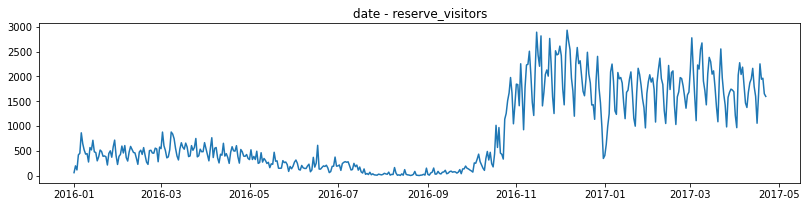

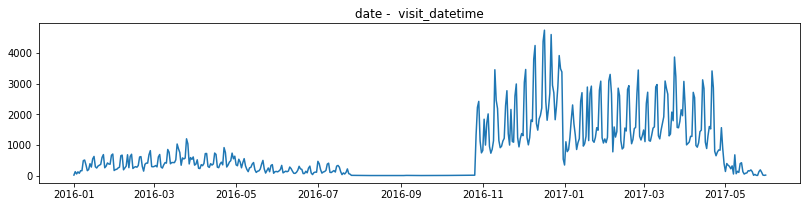

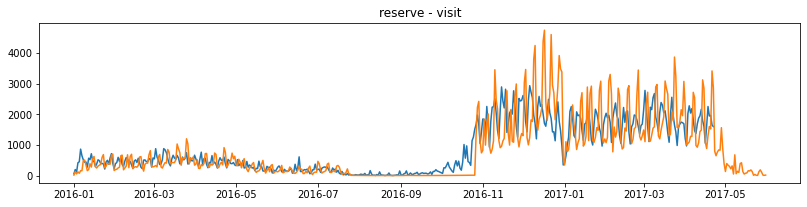

In [22]:
fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(3, 2, 1)
graph1 = plt.plot(air_reserve.groupby('reserve_datetime').sum())
plt.title("date - reserve_visitors")

fig = plt.figure(figsize=(30, 10))
ax2 = fig.add_subplot(3, 2, 2)
graph2 = plt.plot(air_reserve.groupby('visit_datetime').sum())
plt.title("date -  visit_datetime")

fig = plt.figure(figsize=(30, 10))
ax3 = fig.add_subplot(3, 2, 3)
graph3 = plt.plot(air_reserve.groupby('reserve_datetime').sum())
graph4 = plt.plot(air_reserve.groupby('visit_datetime').sum())
plt.title("reserve - visit")

plt.show()

2016년의 방문예약은 많이 저조해보이고, 심지어 긴시간 없는 구간도 보인다. 16년 연말 동안만 예약이 늘었다.

## hpg reserve 파일 시각화

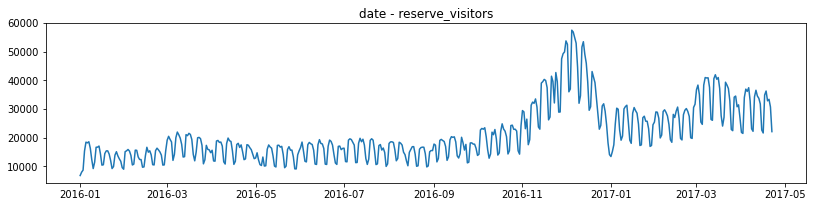

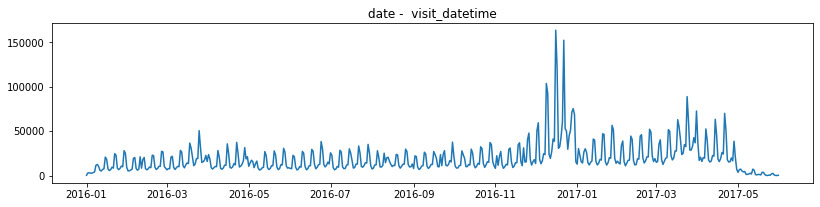

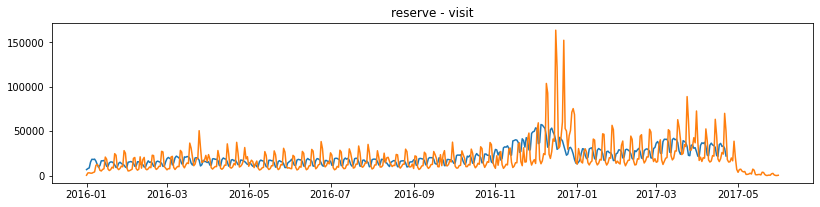

In [23]:
fig = plt.figure(figsize=(30, 10))
ax4 = fig.add_subplot(3, 2, 4)
graph5 = plt.plot(hpg_reserve.groupby('reserve_datetime').sum())
plt.title("date - reserve_visitors")

fig = plt.figure(figsize=(30, 10))
ax5 = fig.add_subplot(3, 2, 5)
graph6 = plt.plot(hpg_reserve.groupby('visit_datetime').sum())
plt.title("date -  visit_datetime")

fig = plt.figure(figsize=(30, 10))
ax6= fig.add_subplot(3, 2, 6)
graph7 = plt.plot(hpg_reserve.groupby('reserve_datetime').sum())
graph8 = plt.plot(hpg_reserve.groupby('visit_datetime').sum())
plt.title("reserve - visit")

plt.show()

예약 방문 고객은 2016년 12월에 많아지는 패턴을 보이며, 위의 ‘air’ data와 같이 time frame의 끄트머리는 수치가 떨어지는걸 볼 수 있다.

## air_reserve / hpg_reserve 파일의 전처리
- 시간 별 컬럼을 생성

In [24]:
#7번
#air_reserve 호출
visit_hour_con = pd.read_csv('visit_hours_con.csv',engine='python')
visit_hour_con.columns = ['store_id','visit_date','reserve_visitors',
                            'air_00hour','air_01hour','air_02hour','air_03hour',
                            'air_04hour','air_05hour','air_06hour','air_07hour',
                            'air_08hour','air_09hour','air_10hour','air_11hour',
                            'air_12hour','air_13hour','air_14hour','air_15hour',
                            'air_16hour','air_17hour','air_18hour','air_19hour',
                            'air_20hour','air_21hour','air_22hour','air_23hour']
data1=pd.merge(data,visit_hour_con,how='outer')
data1=data1[:284127]
data1=data1.fillna('0')

In [25]:
data1.head(3)

,store_id,visit_date,year,month,day,dow,visitors,holiday_flg,next_holiday,air_genre_name,...,air_14hour,air_15hour,air_16hour,air_17hour,air_18hour,air_19hour,air_20hour,air_21hour,air_22hour,air_23hour
0,air_0f0cdeee6c9bf3d7,2016-07-01,2016,07,01,4.0,18.0,0.0,0.0,Italian/French,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
1,air_0f0cdeee6c9bf3d7,2016-07-02,2016,07,02,5.0,37.0,0.0,0.0,Italian/French,...,0,0,0,0,0,0,0,0,0,0
2,air_0f0cdeee6c9bf3d7,2016-07-03,2016,07,03,6.0,20.0,0.0,0.0,Italian/French,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#8번
#hpg_to_air reserve
hpg2air_visit_hour_con = pd.read_csv('hpg2air_visit_hours_result.csv',engine='python')
hpg2air_visit_hour_con.columns = ['store_id','visit_date','num','hpg_reserve_visitors',
                            'hpg_air_00hour','hpg_air_01hour','hpg_air_02hour','hpg_air_03hour',
                            'hpg_air_04hour','hpg_air_05hour','hpg_air_06hour','hpg_air_07hour',
                            'hpg_air_08hour','hpg_air_09hour','hpg_air_10hour','hpg_air_11hour',
                            'hpg_air_12hour','hpg_air_13hour','hpg_air_14hour','hpg_air_15hour',
                            'hpg_air_16hour','hpg_air_17hour','hpg_air_18hour','hpg_air_19hour',
                            'hpg_air_20hour','hpg_air_21hour','hpg_air_22hour','hpg_air_23hour']
del hpg2air_visit_hour_con['num']
hpg2air_visit_hour_con.head()
data1.head()

data1=pd.merge(data1,hpg2air_visit_hour_con,how='outer')
data1=data1[:284127]
data1=data1.fillna('0')

In [27]:
data1.head(3)

,store_id,visit_date,year,month,day,dow,visitors,holiday_flg,next_holiday,air_genre_name,...,hpg_air_14hour,hpg_air_15hour,hpg_air_16hour,hpg_air_17hour,hpg_air_18hour,hpg_air_19hour,hpg_air_20hour,hpg_air_21hour,hpg_air_22hour,hpg_air_23hour
0,air_0f0cdeee6c9bf3d7,2016-07-01,2016,07,01,4.0,18.0,0.0,0.0,Italian/French,...,0,0,0,0,0,0,0,0,0,0
1,air_0f0cdeee6c9bf3d7,2016-07-02,2016,07,02,5.0,37.0,0.0,0.0,Italian/French,...,0,0,0,0,0,0,0,0,0,0
2,air_0f0cdeee6c9bf3d7,2016-07-03,2016,07,03,6.0,20.0,0.0,0.0,Italian/French,...,0,0,0,0,0,0,0,0,0,0


In [28]:
data1 = data1.sort_values(by=['visit_date'], axis =0,)
data1 = data1.reset_index(drop=True)
data1.head(3)

,store_id,visit_date,year,month,day,dow,visitors,holiday_flg,next_holiday,air_genre_name,...,hpg_air_14hour,hpg_air_15hour,hpg_air_16hour,hpg_air_17hour,hpg_air_18hour,hpg_air_19hour,hpg_air_20hour,hpg_air_21hour,hpg_air_22hour,hpg_air_23hour
0,air_a083834e7ffe187e,2016-01-01,2016,01,01,4.0,27.0,1.0,1.0,Izakaya,...,0,0,0,0,0,0,0,0,0,0
1,air_db4b38ebe7a7ceff,2016-01-01,2016,01,01,4.0,21.0,1.0,1.0,Dining bar,...,0,0,0,0,0,0,0,0,0,0
2,air_506fe758114df773,2016-01-01,2016,01,01,4.0,4.0,1.0,1.0,Italian/French,...,0,0,0,0,0,0,0,0,0,0


### LabelEncoder로 문자형을 숫자형으로 변환

In [29]:
#카테고리를 수치형으로 변환
from sklearn.preprocessing import LabelEncoder

store_id = LabelEncoder()
data1['store_id']=store_id.fit_transform(data1['store_id'])

visit_date = LabelEncoder()
data1['visit_date']=store_id.fit_transform(data1['visit_date'])

air_genre = LabelEncoder()
data1['air_genre_name']=store_id.fit_transform(data1['air_genre_name'])

air_area = LabelEncoder()
data1['air_area_name']=store_id.fit_transform(data1['air_area_name'])

hpg_genre = LabelEncoder()
data1['hpg_genre_name']=store_id.fit_transform(data1['hpg_genre_name'])

### data를 trian과 test로 분리

In [30]:
train = data1[:252108]
y_train=train['visitors']
del train['visitors']

test = data1[252108:]
y_test=test['visitors']
del test['visitors']

test = test.sort_values(by=['store_id','month','day'], axis =0,)

### train과 test안에 있는 str이랑 int 섞인 데이터들을 int로 전환

In [31]:
x_train=train.apply(pd.to_numeric)
x_test=test.apply(pd.to_numeric)

================================================================================================================

# 히트맵으로 visitor 수와 변수간의 상관관계 분석

                store_id  visit_date       dow  visitors  holiday_flg  \
store_id        1.000000    0.008007 -0.001307 -0.013628    -0.002250   
visit_date      0.008007    1.000000 -0.006768 -0.195366     0.014662   
dow            -0.001307   -0.006768  1.000000  0.157550    -0.029005   
visitors       -0.013628   -0.195366  0.157550  1.000000     0.003516   
holiday_flg    -0.002250    0.014662 -0.029005  0.003516     1.000000   
next_holiday    0.000891    0.012219  0.067219  0.021031     0.289381   
air_genre_name -0.034791   -0.000889 -0.017704  0.052674    -0.005035   
air_area_name  -0.071537    0.004340 -0.000426 -0.018480    -0.006837   
latitude        0.042508    0.015608  0.000791 -0.001878     0.002184   
longitude       0.000826    0.009955 -0.009152 -0.010819    -0.009920   
hpg_genre_name -0.009093   -0.010587 -0.002613  0.061339     0.005487   

                next_holiday  air_genre_name  air_area_name  latitude  \
store_id            0.000891       -0.034791      

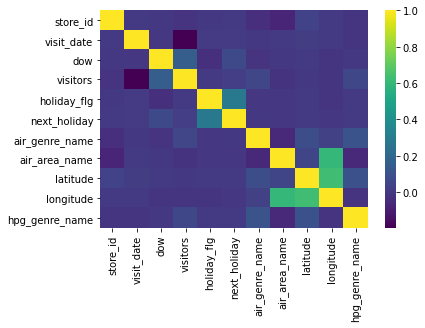

In [32]:
import seaborn as sns

corr = data1.corr()
print(corr)
sns.heatmap(corr, cmap='viridis')
plt.show()

================================================================================================================

# 모델 학습, 예측 및 파일 저장

In [36]:
data_path = os.getenv('HOME')+'/aiffel/hackathon1'

## XGBRegressor

In [37]:
model = XGBRegressor(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    nthread=4,
    scale_pos_weight=1,
    seed=27
)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

submission_path = join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['visitors'] = y_pred

submission_csv_path = '{}/submission_{}_{}.csv'.format(data_path, 'XGB', 'check')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/hackathon1/submission_XGB_check.csv


![1](https://user-images.githubusercontent.com/85026563/128359059-78588326-5206-451f-a953-30aefcccc8f6.jpg)

## LGBMRegressor

In [16]:
model = LGBMRegressor(max_depth=10, n_estimators=1000, random_state=10)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

submission_path = join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['visitors'] = y_pred

submission_csv_path = '{}/submission_{}_{}.csv'.format(data_path, 'LGBM', 'check')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/hackathon1/submission_LGBM_check.csv


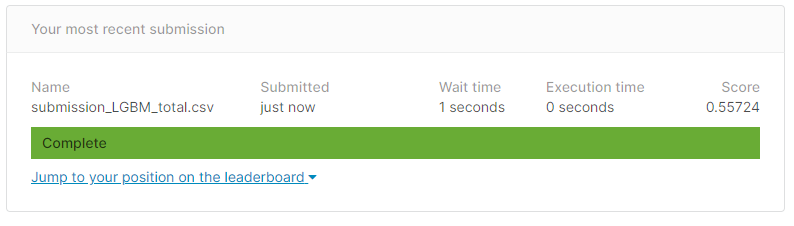

In [93]:
from IPython.display import Image
Image("C:/Users/hoo45/Desktop/lgbm0.55.png")

## RandomForestRegressor

In [16]:
model = RandomForestRegressor(n_estimators=10)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

submission_path = join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['visitors'] = y_pred

submission_csv_path = '{}/submission_{}_{}.csv'.format(data_path, 'RF', 'check')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/hackathon1/submission_RF_check.csv


![2](https://user-images.githubusercontent.com/85026563/128359083-9e5f09bf-74c2-452d-8d7c-6887cb0e1f61.jpg)

## ARDRegression

In [ ]:
from sklearn.linear_model import ARDRegression
ARDR = ARDRegression()
ARDR.fit(x_train, y_train)

y_pred = ARDR.predict(x_test)
y_pred

import os
from os.path import join
submission_path = join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['visitors'] = y_pred

submission_csv_path = '{}/submission_{}_{}.csv'.format(data_path, 'ARDR', 'total')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

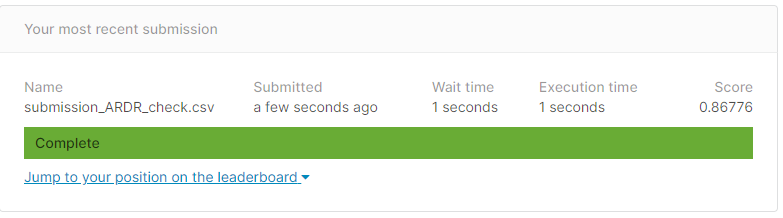

In [94]:
Image("C:/Users/hoo45/Desktop/간단한ardr했을때점수.png")

# 그리드 서치 이용하여 최적의 파라미터 찾기

In [22]:
from sklearn.model_selection import GridSearchCV

params = { 'n_estimators' : [100],
           'max_depth' : [6, 8, 10],
           'min_samples_leaf' : [8, 12],
           'min_samples_split' : [8, 16]
            }

# RandomForestRegressor 객체 생성 후 GridSearchCV 수행
model = RandomForestRegressor(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(model, param_grid = params, cv = 5, n_jobs = -1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.1863


In [19]:
model = RandomForestRegressor(
    min_samples_leaf=8,
    n_estimators=100,
    max_depth=12,
    min_samples_split=8,
    random_state = 0,
    n_jobs = -1,
)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

submission_path = join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['visitors'] = y_pred

submission_csv_path = '{}/submission_{}_{}.csv'.format(data_path, 'RF', 'check')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/hackathon1/submission_RF_check.csv


In [19]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' : [10, 50, 100, 150, 200], 'learning_rate': [0.001, 0.05, 0.1, 0.15, 0.2], 'max_depth' : [8, 10, 12, 14]}

# LGBMRegressor 객체 생성 후 GridSearchCV 수행
model = LGBMRegressor(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(model, param_grid = params, cv = 5, n_jobs = -1)
grid_cv.fit(x_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
최고 예측 정확도: 0.4733


In [98]:
from keras.callbacks import EarlyStopping

from keras.layers.normalization import BatchNormalization#정규화시켜줌
from keras.layers import Dropout
from keras import regularizers
from keras import backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dropout

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, random_state=20, test_size=0.2)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model=keras.models.Sequential()

model.add(keras.layers.Dense(256, activation='relu',input_shape=[len(X_train.keys())]))
#model.add(keras.layers.Dropout(0.2))
#model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(128, activation='relu'))
#model.add(keras.layers.Dropout(0.2))
#model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(1))

model.compile(loss=root_mean_squared_error,
                optimizer='Adam')
model.summary()

es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)



model.fit(X_train, Y_train, epochs=1, batch_size=128,callbacks=[es], validation_data=(X_val, Y_val))


y_pred=model.predict(x_test)
y_pred

import os
from os.path import join
submission_path = join('sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['visitors'] = y_pred

submission_csv_path = '{}/submission_{}_{}.csv'.format(data_path, 'dense', 'total')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               16384     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 49,409
Trainable params: 49,409
Non-trainable params: 0
_________________________________________________________________
Train on 201686 samples, validate on 50422 samples
Epoch 1/1
201686/201686 [==============================] - 8s 38us/step - loss: 16.9575 - val_loss: 15.8234
C:/Users/hoo45/Desktop//submission_dense_total.csv


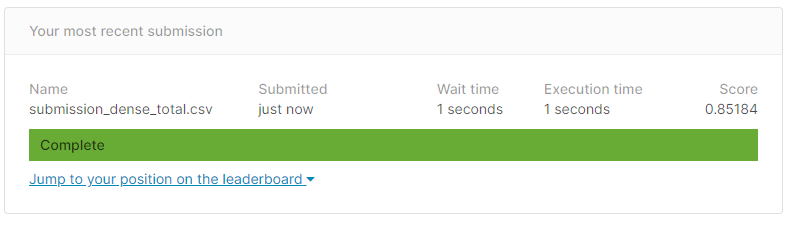

In [99]:
Image("C:/Users/hoo45/Desktop/dense.png")

In [100]:
#정규화해서 돌려보기

data2=data1
y = data2['visitors']
del data2['visitors']

data2=data2.apply(pd.to_numeric)
data3=(data2-data2.min())/(data2.max()-data2.min())

data3['y']=y


train = data3[:252108]
y_train=train['y']
del train['y']

test = data3[252108:]
y_test=test['y']
del test['y']

test = test.sort_values(by=['store_id','month','day'], axis =0,)
train1=train.fillna('0')
test1=test.fillna('0')

In [ ]:
model = LGBMRegressor(learning_rate=0.2,max_depth=10, 
                      n_estimators=200, 
                      random_state=5,
                      num_leaves= 400,
                      feature_fraction= 0.9)
model.fit(train, y_train)
y_pred = model.predict(test)
y_pred

import os
from os.path import join
submission_path = join('sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['visitors'] = y_pred

submission_csv_path = '{}/submission_{}_{}.csv'.format(data_path, 'LGBM_Regul', 'total')
submission.to_csv(submission_csv_path, index=False)

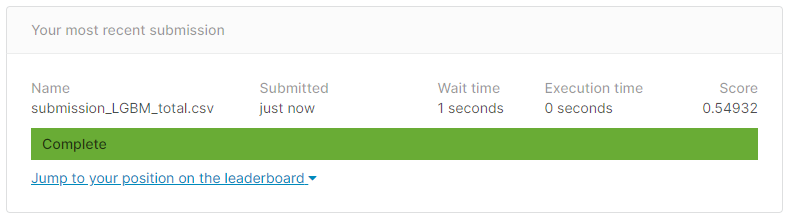

In [101]:
Image("C:/Users/hoo45/Desktop/lgbm0.54.png")

## 전처리 고찰
1. 이상치 탐색한다.
2. 기상 정보 추가한다.
3. 결측치를 다른 처리방법으로 처리
4. 예약 시간과 방문 시간의 고려
5. 식당당 최대 수용인원 파악

## 평가 기준 
**1. EDA 및 Visualization이 충실히 수행되었는가? (25%)**

    - 시각화를 통해 전처리의 틀을 잡을 수 있었다.
    - 상관관계 분석을 통해 변수들의 중요도를 파악했다.
**2. 데이터 전처리가 적절히 수행되었는가? (25%)**

    - 시각화를 통해 알 수 있던 데이터 형태를 변수로 넣었다.
    - 코딩 능력이 되는 부분까지 전처리 기법에 최대한 수행을 했다.
**3. 데이터 분석 과정이 충분히 설득력 있는가? (25%)**

    - 우리 팀이 파악한 데이터 특징을 고려하여 전처리를 진행 했기 때문에 어느정도 있다.
**4. Public Score가 우수한가? (10%)**

    - 0.55
**5. 팀원끼리 서로 협력하여 프로젝트를 수행하고 발표를 진행하였는가?  (15%)**

    - 전처리 진행 중 고려할 변수에 대해 고민함
    - 시각화를 통해 데이터 특징을 파악함
    - 모두가 score를 올리기 위해 노력함

## 느낀점
**- 승환**

    - 데이터의 형태를 파악하고 전처리의 방향을 잡는 과정으로 데이터를 보는 관점이 넓어졌고 원하는 데이터 형태로 전처리 코딩을 하면서 코딩의 중요성도 알 수 있었습니다. score점수를 0.4까지 가고 싶었지만 실력의 한계로 넘지 못해 아쉬움이 있었습니다.
**- 우용**

    - 노드 진행을 해오면서 DataFrame에 대한 이해가 됐다고 생각했는데 막상 실제 데이터를 처리하는 과정에서 아무 함수도 기억이 안나고 적용하기가 힘들었다. 하지만 구글링과 팀원과의 소통으로 데이터의 형상이 점점 잡히고 모델의 성능을 향상시키는 과정을 직접 경험하면서 DataFrame 활용방법이나 Data Plot기법등을 확실하게 익힐 수 있었다고 생각한다. 다른 캐글의 컴피티션을 참여해 또 경험해 보고싶다는 의지까지 생겼다.
**- 진영**

    - 무언가를 시간제한 두고 하니까 확실히 압박받는 느낌으로 더 열심히 하게 되는 것 같고 전처리의 중요도와 어려움에 대해 확실히 느끼게 되었다. 시각화를 하는 것도 결코 쉬운 영역이 아니라는 걸 깨달았다.

## 필기 자랑

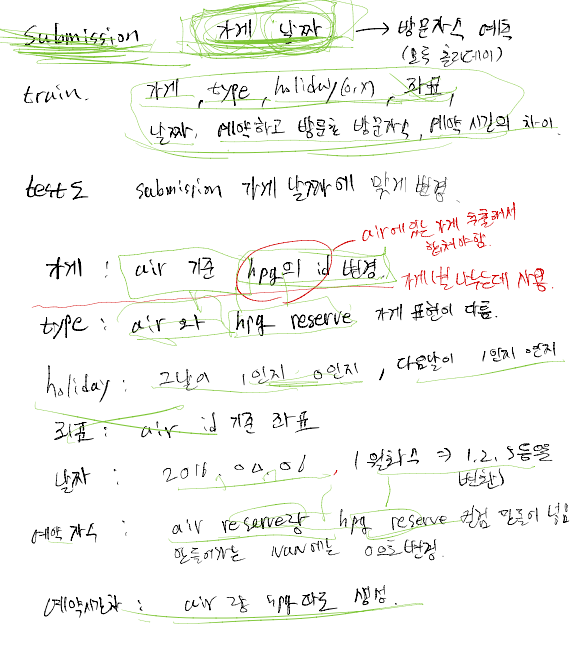

In [102]:
Image("C:/Users/hoo45/Desktop/필기.png")

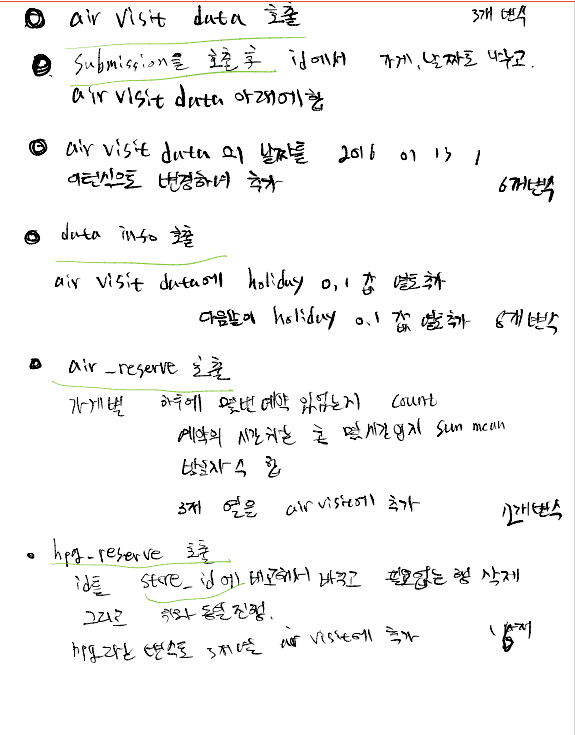

In [103]:
Image("C:/Users/hoo45/Desktop/필기1.png")

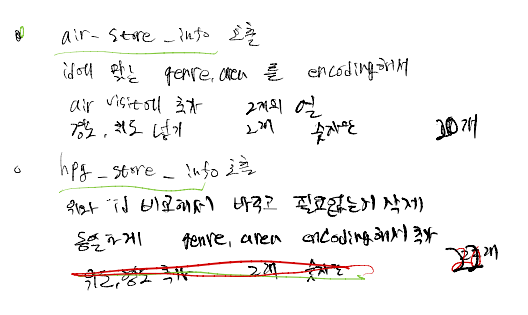

In [105]:
Image("C:/Users/hoo45/Desktop/필기3.png")

시간이 있었다면 더 잘했음 ㄹㅇ..ㅋ